In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Modeli daha hızlı eğitmek için CPU yerine GPU seçtik. Bunun uygulanabilmesi için birkaç program indirilmesi gerekmektedir.
# Gerekenlere buradan ulaşabilirsiniz: https://www.tensorflow.org/install/gpu
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
import pathlib
data_dir = pathlib.Path("./augmented")
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)
NoDR = list(data_dir.glob('0/*'))
print(str(NoDR[0]))
#PIL.Image.open(str(NoDR[0]))

50000
augmented\0\0_original_10035_right.jpeg_0116551e-374b-4b59-95b5-da0ff57a2985.jpeg


In [4]:
batch_size = 16
img_height = 512 #int(1024 / 2) #576
img_width = 512 #int(1024 / 2) #768

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=142,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50000 files belonging to 5 classes.
Using 35000 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=142,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50000 files belonging to 5 classes.
Using 15000 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


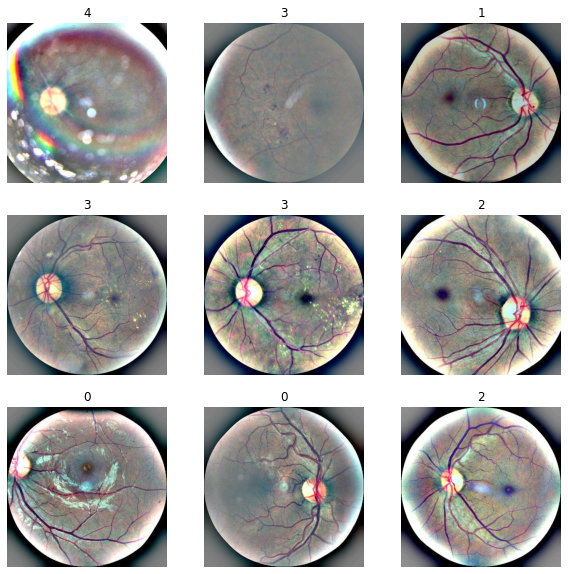

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 512, 512, 3)
(16,)


In [11]:
num_classes = len(class_names) # Kaç tane sınıfımızın olduğunu tutuyoruz

In [12]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet101(include_top=False,
                                                 input_shape=(img_height, img_width, 3),
                                                 pooling='avg',
                                                 classes=num_classes,
                                                 weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation="relu"))
resnet_model.add(layers.Dense(num_classes, activation="softmax"))

In [13]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 43,709,829
Trainable params: 1,051,653
Non-trainable params: 42,658,176
_________________________________________________________________


In [14]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=["accuracy"])

In [15]:
epochs=20
#earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[mcp_save]
)

Epoch 1/20
2188/2188 [==============================] - ETA: 0s - loss: 1.2023 - accuracy: 0.4732

c:\users\monster\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2188/2188 [==============================] - 1824s 830ms/step - loss: 1.2023 - accuracy: 0.4732 - val_loss: 1.1383 - val_accuracy: 0.4919
Epoch 2/20
2188/2188 [==============================] - 2128s 973ms/step - loss: 1.0525 - accuracy: 0.5376 - val_loss: 0.9805 - val_accuracy: 0.5677
Epoch 3/20
2188/2188 [==============================] - 2218s 1s/step - loss: 0.9678 - accuracy: 0.5789 - val_loss: 0.9201 - val_accuracy: 0.5969
Epoch 4/20
2188/2188 [==============================] - 2228s 1s/step - loss: 0.8786 - accuracy: 0.6238 - val_loss: 0.8695 - val_accuracy: 0.6213
Epoch 5/20
2188/2188 [==============================] - 2175s 994ms/step - loss: 0.8099 - accuracy: 0.6578 - val_loss: 0.8006 - val_accuracy: 0.6598
Epoch 6/20
2188/2188 [==============================] - 2191s 1s/step - loss: 0.7271 - accuracy: 0.6996 - val_loss: 0.7561 - val_accuracy: 0.6787
Epoch 7/20
2188/2188 [==============================] - 2069s 946ms/step - loss: 0.6616 - accuracy: 0.7297 - val_loss: 0.7735 

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy'] # Eğitim doğruluğunun değerlerini alıyoruz
val_acc = history.history['val_accuracy'] # Doğrulama doğruluğunun değerlerini alıyoruz

loss = history.history['loss'] # Eğitim kayıp verisini alıyoruz
val_loss = history.history['val_loss'] # Doğrulama kayıp verisini alıyoruz

epochs_range = range(len(history.history["loss"])) # 0'dan [paket sayısı - 1]'e kadar bir dizi oluşturuyoruz [0, 1, ..., epochs - 1]

plt.figure(figsize=(8, 8)) # 8'e 8 boyutlu bir figür oluşturuyoruz
plt.subplot(1, 2, 1) # Doğruluk verisini içeren ilk parçayı ayırıyoruz
plt.plot(epochs_range, acc, label='Training Accuracy') # Eğitim doğruluğunun grafiğini çiziyoruz
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Doğrulama doğruluğunun grafiğini çiziyoruz
plt.legend(loc='lower right') # Legend yazısını sağ alta alıyoruz
plt.title('Training and Validation Accuracy') # Başlığı ayarlıyoruz

plt.subplot(1, 2, 2) # Kayıp verisini içeren ikinci parçayı ayırıyoruz
plt.plot(epochs_range, loss, label='Training Loss') # Eğitim kaybının grafiğini çiziyoruz
plt.plot(epochs_range, val_loss, label='Validation Loss') # Doğruluk kaybının grafiğini çiziyoruz
plt.legend(loc='upper right') # Legend yazısını sağ üste alıyoruz
plt.title('Training and Validation Loss') # Başlığı ayarlıyoruz
plt.show() # Grafiklerimizi gösteriyoruz